In [40]:
import numpy as np
import pathlib as pl
import os
import pandas as pd
import warnings
warnings.simplefilter("ignore")
from copy import copy
import retroBO_analysis_functions as fns
import pickle
import matplotlib.pyplot as plt
import matplotlib as mpl

mpl.style.use('mystyle.mplstyle')

inch_conversion = 1/25.4
page_width = 142.4 *inch_conversion
column_width = 67.2* inch_conversion

# Notebook for Plotting Retrospective Bayesian Optimisation Results

This notebook is for plotting the results of the retrospective Bayesian optimisation on the PCR data.

First specify the results to be plotted.

In [41]:
param_name = 'both' # which parameters
save=False
params = ['r', 'm']

# random_if_none=False
starting_points = ['centre', '0_point_start'] #, '0_point_start', 'centre',
learning_types = ['learning_many', 'learning_1'] #'learning many',

Load the results

In [42]:
res_dfs = {}
results_path = pl.Path(os.getcwd()).parent / 'results'
for key in ['centre_learning_1', '0_point_start_learning_1',
                  'centre_learning_many', '0_point_start_learning_many']:
    res_dfs[key] = pd.read_csv(results_path /f'bayes_opt_{key}.csv', index_col=0)

Check what data is missing

In [43]:
seeds_df = pd.DataFrame(columns=list(res_dfs.keys()),
                        index=res_dfs[f'{starting_points[0]}_learning_many']['PrimerPairReporter'].unique())

for key, df in res_dfs.items():

    for ppr in df['PrimerPairReporter'].unique():
        df_ = df[df['PrimerPairReporter'] == ppr]
        # counts = df_.value_counts('seed').to_frame()
        seeds_df[key][ppr] = len(df_['seed'].unique())

print(seeds_df)

                      centre_learning_1 0_point_start_learning_1  \
FP001-RP001x-EvaGreen                24                       24   
FP002-RP002x-EvaGreen                24                       24   
FP005-FP001-Probe                    24                       24   
RP001x-FP002-Probe                   24                       24   
RP002x-FP005-Probe                   24                       24   
FP005-FP004-EvaGreen                 24                       24   
FP004-RP004-Probe                    24                       24   
RP002x-FP002-EvaGreen                24                       24   
FP001-RP004-EvaGreen                 24                       24   
FP002-RP004-EvaGreen                 24                       24   
FP004-FP005-Probe                    24                       24   
RP008x-FP005-Probe                   24                       24   
FP005-FP001-EvaGreen                 24                       24   
RP002x-FP004-EvaGreen                24         

If necessary, see which seeds are missing data:

In [44]:
for key, df in res_dfs.items():
    print(key)
    counts_df = pd.DataFrame(columns=res_dfs[f'{starting_points[0]}_learning_1']['PrimerPairReporter'].unique())
    for ppr in df['PrimerPairReporter'].unique():
        df_ = df[(df['PrimerPairReporter'] == ppr)  & (df['model'] == 'mo_indi')][['BP', 'GC', 'seed']].drop_duplicates()
        counts = df_.value_counts('seed').to_frame().sort_values(by='seed')
        counts_df[ppr] = df_.value_counts('seed').to_frame().sort_values(by='seed')
        # seeds_df[key][ppr] = len(df_['seed'].unique())
    print(counts_df.T.to_string())

centre_learning_1
seed                   1   2   3   4   5   6   7   8   9   10  11  12  13  14  15  16  17  18  19  20  21  22  23  24
FP004-RP004-Probe      18  16  16  18  16  16  15  16  17  18  17  18  18  18  18  15  18  18  17  19  16  16  16  15
FP001-RP001x-EvaGreen  16  16  17  15  15  16  17  17  16  16  16  15  16  16  18  15  15  17  16  15  17  16  13  14
FP002-RP002x-EvaGreen  14  15  15  15  14  14  15  15  15  15  15  14  15  15  15  15  15  15  15  15  15  15  15  15
FP001-RP001x-Probe     14  14  12  17  14  14  14  15  15  16  14  14  15  12  15  14  14  17  15  15  15  16  13  17
FP005-FP001-Probe       8   8   8   8   8   8   8   8   8   8   8   8   8   8   8   8   8   8   8   8   8   8   8   8
RP001x-FP002-Probe     14  14  13  17  14  16  15  16  15  13  14  14  14  14  17  14  11  10  13  14  13  12  13  13
RP002x-FP005-Probe      8   8   8   8   8   8   8   8   8   8   8   8   8   8   8   8   8   8   8   8   8   8   8   8
FP005-FP004-EvaGreen    8   8   8   8 

In [45]:
df = res_dfs['centre_learning_many']

count_df = df[['PrimerPairReporter', 'seed', 'BP', 'GC']].drop_duplicates()
counts = count_df.value_counts(['PrimerPairReporter', 'seed']).to_frame().sort_values(by=['PrimerPairReporter','seed'])


Calculate the regret

In [49]:
stzd = True
max_iter = 20

if len(params) >1:
    regret_metric = 'combined regret'
else:
    regret_metric = 'regret r'
starting_point_names = {'centre':'Centre', '0_point_start':'Model\'s Choice'}
learning_type_names = {'learning_many':'Learning Many', 'learning_1':'Learning One\nat a Time'}
plot_minmax = True
regrets_all = {}
regret_names = []
for name, df in res_dfs.items():
    best_points = fns.get_best_points_constrained(params, df, stzd=stzd, log_t=False)
    regret_df_all = fns.calculate_regret(df, params, best_points, stzd=stzd, constrained=True,
                                         diff_from_target_only=False)
    regret_df_all = regret_df_all[regret_df_all['iteration'] <=max_iter]
    regrets_all[name] = regret_df_all

In [50]:

cumulative_regrets = {}
for name, regret_df in regrets_all.items():

    if 'r' in params and 'm' in params:
        regret_names = ['combined regret']
    else:
        regret_names = [f'regret {param}' for param in params]

    # if learning_type == 'learning many':
    #     for seed in regret_df['seed'].unique():
    #         temp_df = regret_df[regret_df['seed'] == seed]
    #         if temp_df['iteration'].max() != max_iter:
    #             regret_df= regret_df[regret_df['seed'] != seed]

    regret_df = regret_df.sort_values('iteration')

    # calculate the cumulative minimum regret and cumulative sum of regret

    for model in regret_df['model'].unique():
        for seed in regret_df['seed'].unique():
            for ppr in regret_df['PrimerPairReporter'].unique():
                for regret_name in regret_names:
                    regret_df.loc[
                        (regret_df['model'] == model) & (regret_df['seed'] == seed) & (
                                    regret_df['PrimerPairReporter'] == ppr), f'{regret_name} cummin'] = \
                        regret_df.loc[(regret_df['model'] == model) & (regret_df['seed'] == seed) & (
                                regret_df['PrimerPairReporter'] == ppr), regret_name].cummin()
                    regret_df.loc[
                        (regret_df['model'] == model) & (regret_df['seed'] == seed) & (
                                    regret_df['PrimerPairReporter'] == ppr), f'{regret_name} cumsum'] = \
                        regret_df.loc[(regret_df['model'] == model) & (regret_df['seed'] == seed) & (
                                regret_df['PrimerPairReporter'] == ppr), f'{regret_name} cummin'].cumsum()
    cumulative_regrets[name] = regret_df


In [51]:
regret_metrics = {}
for name, regret_df in cumulative_regrets.items():

    i_max = regret_df['iteration'].max() #.loc[regret_df['model'] =='avg',

    for ppr in regret_df['PrimerPairReporter'].unique():

        ppr_imax = regret_df.loc[regret_df['PrimerPairReporter'] == ppr, 'iteration'].to_numpy().max()
        if ppr_imax == i_max:
            pass
        else:
            extra_rows = pd.concat([regret_df.loc[(regret_df['PrimerPairReporter'] == ppr)
                                            & (regret_df['iteration'] == ppr_imax)]] * int((i_max - ppr_imax)))
            extra_rows = extra_rows.sort_values(['model', 'seed'])
            if ppr_imax < (i_max - 1):
                test = np.arange(ppr_imax + 1, i_max + 1).tolist() * int(len(extra_rows)/(i_max-ppr_imax))
                extra_rows['iteration'] = np.arange(ppr_imax + 1, i_max + 1).tolist() \
                                          * int(len(extra_rows)/(i_max-ppr_imax))
                regret_df = regret_df.append(extra_rows)
            elif ppr_imax == (i_max - 1):
                extra_rows['iteration'] = i_max
                regret_df = regret_df.append(extra_rows)
            else:
                pass
    # if 'learning many' in name:
    df = regret_df.groupby(['model', 'iteration', 'seed']).mean().reset_index()

    df2 = df.groupby(['model', 'iteration']).mean().reset_index()
    df3 = df.groupby(['model', 'iteration']).median().reset_index()
    df4 = df.groupby(['model', 'iteration']).quantile(0.05).reset_index()
    df5 = df.groupby(['model', 'iteration']).quantile(0.95).reset_index()
    metrics = ['mean', 'median', 'min', 'max']

    dfs = [df2, df3, df4, df5]
    for i in range(len(dfs)):
        for col in [f'{regret_name} {met}' for regret_name in regret_names for met in ['cummin', 'cumsum']]:
            dfs[i][f'{metrics[i]} {col}'] = dfs[i][col]
        dfs[i] = dfs[i].drop(
            columns=[f'{regret_name} {met}' for regret_name in regret_names for met in ['cummin', 'cumsum']]
                    + ['seed', 'index'] + regret_names)
    regret_df = dfs[0].merge(dfs[1], on=['model', 'iteration'])
    regret_df = regret_df.merge(dfs[2], on=['model', 'iteration'])
    regret_df = regret_df.merge(dfs[3], on=['model', 'iteration'])

    # else:
    #
    #     # calculate the mean, min, and max of the cumulative minimum regret and cumulative sum of
    #     # regret across all seeds for each primer pair reporter
    #
    #     df4 = regret_df.groupby(['model', 'iteration', 'PrimerPairReporter']).mean().reset_index()
    #     df7 = regret_df.groupby(['model', 'iteration', 'PrimerPairReporter']).median().reset_index()
    #     df5 = regret_df.groupby(['model', 'iteration', 'PrimerPairReporter']).quantile(0.05).reset_index()
    #     df6 = regret_df.groupby(['model', 'iteration', 'PrimerPairReporter']).quantile(0.95).reset_index()
    #
    #     # create new dataframe which combines these metrics
    #
    #     metrics = ['mean', 'min', 'max', 'median']
    #     dfs = [df4, df5, df6, df7]
    #     for i in range(len(dfs)):
    #         for col in [f'{regret_name} {met}' for regret_name in regret_names for met in ['cummin', 'cumsum']]:
    #             dfs[i][f'{metrics[i]} {col}'] = dfs[i][col]
    #         dfs[i] = dfs[i].drop(
    #             columns=[f'{regret_name} {met}' for regret_name in regret_names for met in ['cummin', 'cumsum']]
    #                     + ['seed', 'index'] + regret_names)
    #
    #     regret_df = dfs[0].merge(dfs[1], on=['model', 'iteration', 'PrimerPairReporter'])
    #     regret_df = regret_df.merge(dfs[2], on=['model', 'iteration', 'PrimerPairReporter'])
    #     regret_df = regret_df.merge(dfs[3], on=['model', 'iteration', 'PrimerPairReporter'])


    regret_df = regret_df.groupby(['model', 'iteration']).mean().reset_index()
    regret_metrics[name] = regret_df

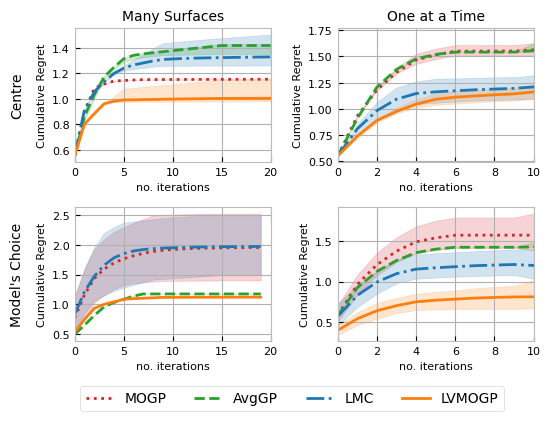

In [52]:
linestyles = {'lmc':'dashdot', 'mo_indi': 'dotted', 'lvm':  'solid' , 'avg': 'dashed' }
def get_colors():
    cols = plt.rcParams['axes.prop_cycle'].by_key()['color']
    cols = ['#253494', '#2c7fb8','#41b6c4',  '#a1dab4']
    colors = {'lmc': cols[0], 'mo_indi': cols[3], 'lvm': cols[1], 'avg': cols[2]}
    return colors

starting_point_names = {'centre':'Centre', '0_point_start':'Model\'s Choice'}
learning_type_names = {'learning many':'Many Surfaces', 'learning 1':'One at a Time'}
labels = {'mo_indi':'MOGP', 'avg':'AvgGP', 'lmc': 'LMC', 'lvm':'LVMOGP'}

fig, axs = plt.subplots(nrows=2, ncols=2, figsize=[page_width, page_width*0.7])
colors = fns.get_colors()
plot_minmax=True
starting_point_names = {'centre':'Centre', '0_point_start':'Model\'s Choice'}
learning_type_names = {'learning_many':'Many Surfaces', 'learning_1':'One at a Time'}
labels = {'mo_indi':'MOGP', 'avg':'AvgGP', 'lmc': 'LMC', 'lvm':'LVMOGP'}
for name, regret_df in regret_metrics.items():
    if 'centre' in name:
        j = 0
    elif '0_point_start' in name:
            j=1
    if 'learning_many' in name:
        i=0
        learning_type = 'learning_many'
    elif 'learning_1' in name:
        i=1
        learning_type = 'learning_1'

    for model in ['mo_indi', 'avg', 'lmc', 'lvm']:
        df = regret_df[(regret_df['model'] == model) ].sort_values('iteration')
        if (j==0) & (i==0):
            label = labels[model]
        else:
            label = None
        axs[j, i].plot(df['iteration'], df[f'mean {regret_metric} cumsum'], label=label,
                       color=colors[model], linestyle=linestyles[model])
        if plot_minmax:
            axs[j, i].fill_between(df['iteration'], df[f'min {regret_metric} cumsum'],
                                   df[f'max {regret_metric} cumsum'],
                                   alpha=0.2, color=colors[model])
    axs[0, i].set_title(f'{learning_type_names[learning_type]}', fontsize=10)
    axs[j, i].set_ylabel(f'Cumulative Regret')
    axs[1, i].set_xlabel('no. iterations')
    axs[0, i].set_xlabel('no. iterations')

rows = [f'{row}' for row in starting_point_names.values()]
for ax, row in zip(axs[:,0], rows):
    ax.annotate(row, xy=(0, 0.5), xytext=(-ax.yaxis.labelpad - 5, 0),
                xycoords=ax.yaxis.label, textcoords='offset points',
                fontsize=10, ha='right', va='center', rotation=90)
for ax in axs[:, 1]:
    ax.set_xlim(0, 10)
for ax in axs[:, 0]:
    ax.set_xlim(0, 20)

        # plt.suptitle('Cumulative Regret')
        # axs[j, i].legend()

fig.legend(loc="lower center", ncols=4,
               bbox_to_anchor=(0.53, -0.08))
plt.tight_layout()
plt.savefig(f'plots/retroBO_cumulative_regret_all_{param_name}.pdf', bbox_inches='tight')
plt.savefig(f'plots/retroBO_cumulative_regret_all_{param_name}.svg', bbox_inches='tight')


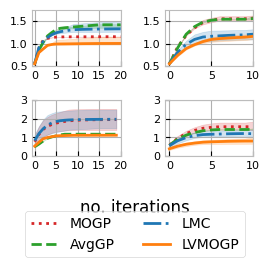

In [53]:


fig, axs = plt.subplots(nrows=2, ncols=2, figsize=[0.5*page_width, 0.4*page_width])
colors = fns.get_colors()
plot_minmax=True

for name, regret_df in regret_metrics.items():

    if 'centre' in name:
        j = 0
    elif '0_point_start' in name:
        j=1
    if 'learning_many' in name:
        i=0
        learning_type = 'learning_many'
    elif 'learning_1' in name:
        i=1
        learning_type = 'learning_1'
    for model in ['mo_indi', 'avg', 'lmc', 'lvm']:
        df = regret_df[(regret_df['model'] == model) ].sort_values('iteration')
        if (j==0) & (i==0):
            label = labels[model]
        else:
            label = None
        axs[j, i].plot(df['iteration'], df[f'mean {regret_metric} cumsum'], label=label,
                       color=colors[model], linestyle=linestyles[model])
        if plot_minmax:
            axs[j, i].fill_between(df['iteration'], df[f'min {regret_metric} cumsum'],
                                   df[f'max {regret_metric} cumsum'],
                                   alpha=0.2, color=colors[model])
        # axs[0, i].set_title(f'{learning_type_names[learning_type]}', fontsize=10)

for ax in axs[:, 1]:
    ax.set_xlim(-0.5, 10)
    ax.set_xticks([0, 5, 10])
for ax in axs[:, 0]:
    ax.set_xlim(-0.5, 20)
    ax.set_xticks([0, 5, 10, 15, 20])

for ax in axs[0, :]:
    ax.set_ylim(0.5, 1.75)
    ax.set_yticks([0.5, 1,  1.5, ])
for ax in axs[1, :]:
    ax.set_ylim(0, 3)
    ax.set_yticks([0,  1, 2, 3])

rows = [f'{row}' for row in starting_point_names.values()]

fig.legend(loc="lower center", ncols=2,
               bbox_to_anchor=(0.5, -0.2))
fig.supxlabel('no. iterations')
plt.subplots_adjust(hspace=0.4, wspace=0.4, left=None, bottom=0.18, right=None, top=1)

plt.tight_layout()
plt.savefig(f'plots/retroBO_cumulative_regret_both_half_wlines.pdf', bbox_inches='tight')
plt.savefig(f'plots/retroBO_cumulative_regret_both_half_wlines.svg', bbox_inches='tight')

In [54]:
if len(params) >1:
    regret_metric = 'combined regret'
else:
    regret_metric = 'regret r'
win_dfs = {}
win_dfs_cum_regrets = {}
# for i, learning_type in enumerate(['learning many', 'learning 1']):
#     for j, starting_point in enumerate(starting_points):
for name, df in res_dfs.items():
    best_points = fns.get_best_points_constrained(params, df, stzd=stzd, log_t=False)
    regret_df1 = fns.calculate_regret(df, params, best_points, stzd=stzd, constrained=True)
    regret_df1 =regret_df1[regret_df1['iteration']<= max_iter]
    win_df, win_df_totals = fns.get_win_counts(regret_df1, regret_metric)
    win_df_cum_regret, win_df_totals_cum_regret = fns.get_cum_regret_table(regret_df1, regret_name=regret_metric)
    win_dfs[name] = win_df
    win_dfs_cum_regrets[name] = win_df_cum_regret
    print(name)
    print('first to zero')
    print(win_df_totals[['mo_indi','avg','lmc', 'lvm']])
    print('lowest cumulative regret')
    print(win_df_totals_cum_regret[['mo_indi','avg',  'lmc', 'lvm']])

centre_learning_1
first to zero
  mo_indi  avg  lmc  lvm
0     141  137  153  217
lowest cumulative regret
  mo_indi  avg  lmc  lvm
0     173  118  139  204
0_point_start_learning_1
first to zero
  mo_indi  avg lmc  lvm
0      68  100  74  202
lowest cumulative regret
  mo_indi avg lmc  lvm
0      99  62  43  172
centre_learning_many
first to zero
  mo_indi  avg  lmc  lvm
0     142  157  123  165
lowest cumulative regret
  mo_indi  avg  lmc  lvm
0     180  118  100  163
0_point_start_learning_many
first to zero
  mo_indi  avg  lmc  lvm
0      89  122  101  111
lowest cumulative regret
  mo_indi  avg lmc  lvm
0      85  103  84  111


Average number of iterations to best best_points

In [55]:
import math

if len(params) >1:
    regret_metric = 'combined regret'
else:
    regret_metric = 'regret r'
win_dfs = {}
win_dfs_cum_regrets = {}

for name, df in res_dfs.items():
    best_points = fns.get_best_points_constrained(params, df, stzd=stzd, log_t=False)
    regret_df1 = fns.calculate_regret(df, params, best_points, stzd=stzd, constrained=True)

    df = regret_df1
    avg_iter_df = pd.DataFrame(columns=['PrimerPairReporter'] + list(df['model'].unique()))
    avg_iter_df['PrimerPairReporter'] = df['PrimerPairReporter'].unique()
    for ppr in df['PrimerPairReporter'].unique():
        zero_regret_dict = {model:[] for model in df['model'].unique()}
        for seed in range(1, 21):
            temp_df = df[(df['PrimerPairReporter'] == ppr) & (df['seed'] == seed)]
            if len(temp_df) < 1:
                pass
            else:
                for model in temp_df['model'].unique():
                    temp_1 = temp_df[(temp_df['model'] == model) & (temp_df[regret_metric] <= 1e-8)]
                    temp_2 = temp_df[(temp_df['model'] == model) & (temp_df['regret r'] <= 0.05)
                                         & (temp_df['regret m'] < 1e-8)]

                    temp_3 = pd.concat([temp_1, temp_2])
                    zero_regret_dict[model].append(np.min(temp_3['iteration']))
        for model in df['model'].unique():
            if np.isnan(zero_regret_dict[model]).any():
                print(f'{name} {ppr} {model} has {np.isnan(zero_regret_dict[model]).sum()} NaNs')
            avg_iter_df.loc[avg_iter_df['PrimerPairReporter'] == ppr, model] = np.mean(zero_regret_dict[model])
    print(name)
    print(avg_iter_df)
    print(avg_iter_df.dropna(subset=list(df['model'].unique())).mean())

centre_learning_1 FP004-RP004-Probe lmc has 2 NaNs
centre_learning_1 FP004-RP004-Probe lvm has 20 NaNs
centre_learning_1 FP004-RP004-Probe mo_indi has 1 NaNs
centre_learning_1
       PrimerPairReporter  avg   lmc   lvm mo_indi
0   FP001-RP001x-EvaGreen  5.0   8.3   4.0     4.0
1      FP001-RP001x-Probe  4.0  4.85   9.3     7.0
2    FP001-RP004-EvaGreen  6.0   3.4   1.9     5.0
3   FP002-RP002x-EvaGreen  1.0   3.4  1.85     1.0
4    FP002-RP004-EvaGreen  1.0   1.0   1.0     1.0
5       FP004-FP005-Probe  4.0   2.0   4.4     6.0
6       FP004-RP004-Probe  7.0   NaN   NaN     NaN
7    FP005-FP001-EvaGreen  1.0   2.0  1.65     1.0
8       FP005-FP001-Probe  7.0   4.9   3.8     2.0
9    FP005-FP004-EvaGreen  0.0   0.0   0.0     0.0
10     RP001x-FP002-Probe  4.0  2.55   1.0     4.9
11  RP002x-FP002-EvaGreen  1.0   1.0   1.0     1.0
12  RP002x-FP004-EvaGreen  3.0  1.85   1.0     3.0
13     RP002x-FP005-Probe  0.0   0.0   0.0     0.0
14  RP008x-FP001-EvaGreen  5.0  3.05   3.1     4.0
15     R


Below gives a dataframe of the regret of the first points

In [56]:
first_regret_df = pd.DataFrame(columns=['model', 'starting point & learning type', 'mean', 'min', 'max'])
first_regret_df['model'] = ['avg', 'mo_indi', 'lmc', 'lvm'] * 4
first_regret_df['starting point'] = ['centre'] * 4 + ['0_point_start'] * 4 + ['centre'] * 4 + ['0_point_start'] * 4
first_regret_df['learning type'] = ['learning many'] * 8 + ['learning 1'] * 8
dfs = []
for name, regret_df in regret_metrics.items():
    if 'not random' in name:
        pass
        # regret_df = regrets[learning_type][starting_point]
    else:
        for mod_name in regret_df['model'].unique():
            df_ = regret_df[(regret_df['model']==mod_name) & (regret_df['iteration'] == np.min(regret_df['iteration']))]
            new_df = pd.DataFrame(data=[[mod_name, name, df_['mean combined regret cummin'].to_numpy()[0],
                                         df_['min combined regret cummin'].to_numpy()[0],
                                         df_['max combined regret cummin'].to_numpy()[0] ]],
                                  columns=['model', 'starting point & learning type', 'mean', 'min', 'max'])
            dfs.append(new_df)

first_regret_df = pd.concat(dfs, ignore_index=True)
print(first_regret_df.to_string())
print('lvm only:')
print(first_regret_df[first_regret_df['model']== 'lvm'].to_string())

      model starting point & learning type      mean       min       max
0       avg              centre_learning_1  0.551191  0.551191  0.551191
1       lmc              centre_learning_1  0.551191  0.551191  0.551191
2       lvm              centre_learning_1  0.551191  0.551191  0.551191
3   mo_indi              centre_learning_1  0.551191  0.551191  0.551191
4       avg       0_point_start_learning_1  0.576148  0.576148  0.576148
5       lmc       0_point_start_learning_1  0.568577  0.454511  0.726015
6       lvm       0_point_start_learning_1  0.396105  0.336679  0.460926
7   mo_indi       0_point_start_learning_1  0.584609  0.503526  0.707510
8       avg           centre_learning_many  0.551191  0.551191  0.551191
9       lmc           centre_learning_many  0.551191  0.551191  0.551191
10      lvm           centre_learning_many  0.551191  0.551191  0.551191
11  mo_indi           centre_learning_many  0.551191  0.551191  0.551191
12      avg    0_point_start_learning_many  0.50172